### Import

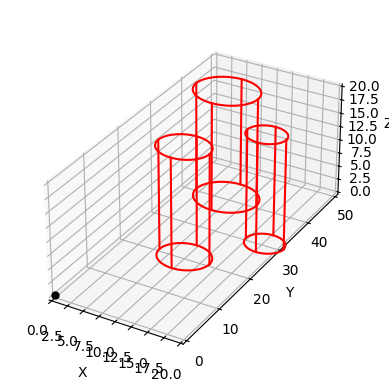

RRT*


IntProgress(value=0, max=500)

Goal found
Timesteps: 75
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 917.00us ( 41.68us)        22
       nlp_g  |        0 (       0) 740.00us ( 33.64us)        22
  nlp_grad_f  |        0 (       0) 436.00us ( 72.67us)         6
  nlp_hess_l  |   1.00ms ( 55.56us)   7.26ms (403.11us)        18
   nlp_jac_g  |        0 (       0)   3.75ms (170.45us)        22
       total  |  69.00ms ( 69.00ms)  75.17ms ( 75.17ms)         1
Solver failed to find a solution.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  11.00ms ( 33.74us)  17.84ms ( 54.72us)       326
       nlp_g  |  18.00ms ( 55.21us)  14.18ms ( 43.50us)       326
  nlp_grad_f  |  34.00ms (151.79us)  20.06ms ( 89.56us)       224
  nlp_hess_l  | 169.00ms (734.78us) 124.79ms (542.59us)       230
   nlp_jac_g  |  77.00ms (296.15us)  56.83ms (218.58us)       260
       total  |   1.35 s (  1.35 s)   1.35 s (  1.35 s)         1
Optimal cost: 142

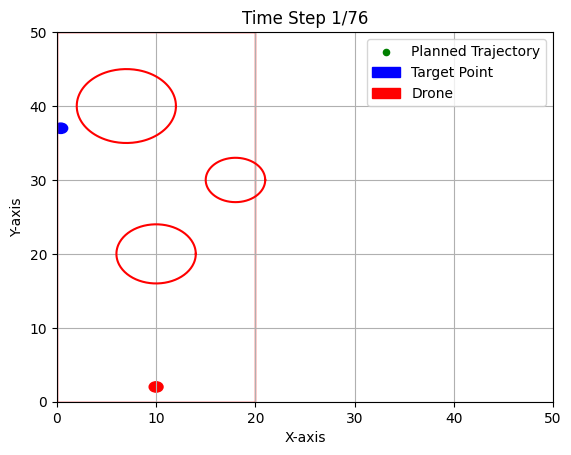

In [2]:
# Libraries
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D

# Files
from vehicle import *
from plotting import *
from simulate import *
from mpc import *
from global_path_planning import *
from obstacles import *

#### MPC Properties
dt = 1                  # Time step [s]
N = 20                 # Time Horizon

####  Simulation/Problem Parameters
pos_constraints = [0, 20, 0, 50, 0, 20]         # Position Constraints [m]:    [x_min, x_max, y_min, y_max, z_min, z_max	]
x_init = [10, 2, 2, 0, 0, 0]          # Initial State: [x, y, z, x_dot, y_dot, z_dot]
x_target_last = [10, 48, 2, 0, 0, 0]      # Target State: [x, y, z, x_dot, y_dot, z_dot]
T = 75                                   # Simulation time [s]

#### Drone Velocity & Acceleration Constraints
vel_constraints = [-1, 1, -1, 1, -1, 1]         # Velocity Constraints [m/s]:  [x_min, x_max, y_min, y_max, z_min, z_max] 
acc_constraints = [-10, 10, -10, 10, -10, 10]         # Acceleration Constraints [m/s^2]:    [x_min, x_max, y_min, y_max, z_min, z_max]

#### Obstacles
static_cost = 300
dynamic_cost = 400

waypoint_radius = 3

#### OBSTACLE DEFINITION 

## Vertical Obstacles
V_obstacles = [[10, 20, 4], [18, 30, 3], [7, 40, 5]]
V_move_obstacles = [[20, 40, -0.7, 0, 4], [17, 0, 0, 1, 4], [0, 0, 1, 1, 2]]  # [center_x, center_y, vel_x, vel_y, radius]
H_obstacles = []         # [center_x, center_y, radius]
H_move_obstacles = []  # [center_x, center_y, vel_x, vel_y, radius]


obstacles, move_obstacles = init_obstacles(V_obstacles, V_move_obstacles, H_obstacles, H_move_obstacles, static_cost, dynamic_cost)

# Run RRT*
#get global a_star path and visualize
World = World_3D([pos_constraints[0], pos_constraints[1]], [pos_constraints[2], pos_constraints[3]], [pos_constraints[4], pos_constraints[5]], obstacles, move_obstacles, obstacle_margin=0.5)
World.plot()

print("RRT*")
path_rrt = rrt_star(World, x_init[:3], x_target_last[:3], radius=15, max_iter=500)

# Setup vehichle & controller then Simulate
vehicle = vehicle_SS(dt)
controller = lambda x_init, current_wp, last_plan : mpc_control(vehicle, N, x_init, current_wp, pos_constraints, vel_constraints, acc_constraints, last_plan, obstacles, move_obstacles)
states, inputs, plans, timesteps, target_state = simulate(dt, T, x_init, x_target_last, N, controller, move_obstacles, path_rrt, waypoint_radius, num_states=6, num_inputs=3)

obstacles, move_obstacles = init_obstacles(V_obstacles, V_move_obstacles, H_obstacles, H_move_obstacles, static_cost, dynamic_cost)

def update(frame):
    # Clear previous frame
    plt.cla()

    # Plot Path for current state
    plt.scatter(plans[0][:, frame], plans[1][:, frame], c='g', s=20, label = "Planned Trajectory")

    # Plot current state
    TargetPoint = plt.Circle((target_state[0][frame], target_state[1][frame]), 0.7, color='b', fill=True, label = "Target Point")
    plt.gca().add_patch(TargetPoint)

    drone = plt.Circle((states[0][frame], states[1][frame]), 0.7, color='r', fill=True, label = "Drone")
    plt.gca().add_patch(drone)
    
    MovingObstacleConvert(move_obstacles, dt)

    # Plot Environment
    World.plot2d_ax(plt.gca())

    for move_obstacle in move_obstacles:
        move_obstacle.plot_xy(plt.gca(), 'red')

    # Env Boundaries
    x = pos_constraints[0]
    y = pos_constraints[2]
    width = pos_constraints[1]-x
    height = pos_constraints[3]-x
    rectangle = patches.Rectangle((x, y), width, height, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rectangle)

    plt.legend()
    plt.title(f'Time Step {frame + 1}/{len(states[1])}')  # Set title for each frame
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.grid()

# Create the animation
fig = plt.figure()
ani = FuncAnimation(fig, update, frames=len(states[1]), interval=100)

# Display the animation within the Jupyter Notebook using HTML
HTML(ani.to_jshtml())
 

In [3]:
#### OBSTACLE DEFINITION 

## Vertical Obstacles
# V_obstacles = [[10, 20, 4], [18, 30, 3], [7, 40, 5]]         # [center_x, center_y, radius]
V_obstacles = [[10, 10, 4], [4, 20, 3], [15, 40, 3]]         # [center_x, center_y, radius]

# V_move_obstacles = [[20, 40, -0.7, 0, 5], [17, 0, 0, 1, 5]]  # [center_x, center_y, vel_x, vel_y, radius]
V_move_obstacles = []  # [center_x, center_y, vel_x, vel_y, radius]

H_obstacles = []         # [center_x, center_y, radius]
H_move_obstacles = []  # [center_x, center_y, vel_x, vel_y, radius]

obstacles = []
move_obstacles = []

# Class Creation
for V_obstacle in V_obstacles:
    obstacles.append(CylinderVertical(V_obstacle[0], V_obstacle[1], V_obstacle[2], static_cost))

for H_obstacle in H_obstacles:
    obstacles.append(CylinderHorizontal(H_obstacle[0], H_obstacle[1], H_obstacle[2], static_cost))

for V_move_obstacle in V_move_obstacles:
    move_obstacles.append(CylinderVertical(V_move_obstacle[0], V_move_obstacle[1], V_move_obstacle[4], dynamic_cost, V_move_obstacle[2:4]))

for H_move_obstacle in V_move_obstacles:
    move_obstacles.append(CylinderHorizontal(H_move_obstacle[0], H_move_obstacle[1], H_move_obstacle[4], dynamic_cost, H_move_obstacle[2:4]))


In [4]:
# Run RRT*
#get global a_star path and visualize
World = World_3D([pos_constraints[0], pos_constraints[1]], [pos_constraints[2], pos_constraints[3]], [pos_constraints[4], pos_constraints[5]], obstacles,  obstacle_margin=0.5)
World.plot()

start = x_init[:3]
goal = x_target_last[:3]

print("RRT*")
path_rrt = rrt_star(World, start, goal, radius=10, max_iter=500)


TypeError: __init__() missing 1 required positional argument: 'move_obstacles'

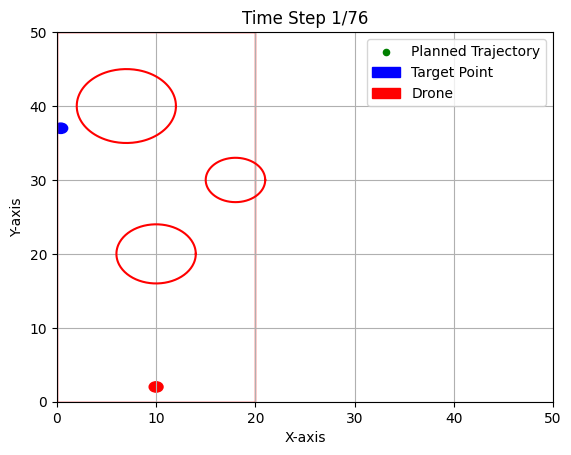

In [5]:
def update(frame):
    # Clear previous frame
    plt.cla()

    # move_obstacles_update = MovingObstacleConvert(move_obstacles, frame, dt)

    # Plot Path for current state
    plt.scatter(plans[0][:, frame], plans[1][:, frame], c='g', s=20, label = "Planned Trajectory")

    # Plot current state
    TargetPoint = plt.Circle((target_state[0][frame], target_state[1][frame]), 0.7, color='b', fill=True, label = "Target Point")
    plt.gca().add_patch(TargetPoint)

    drone = plt.Circle((states[0][frame], states[1][frame]), 0.7, color='r', fill=True, label = "Drone")
    plt.gca().add_patch(drone)
    
    # Plot Environment
    World.plot2d_ax(plt.gca())

    # Env Boundaries
    x = pos_constraints[0]
    y = pos_constraints[2]
    width = pos_constraints[1]-x
    height = pos_constraints[3]-x
    rectangle = patches.Rectangle((x, y), width, height, edgecolor='red', facecolor='none')
    plt.gca().add_patch(rectangle)

    plt.legend()
    plt.title(f'Time Step {frame + 1}/{len(states[1])}')  # Set title for each frame
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    plt.grid()

# Create the animation
fig = plt.figure()
ani = FuncAnimation(fig, update, frames=len(states[1]), interval=100)

# Display the animation within the Jupyter Notebook using HTML
HTML(ani.to_jshtml())
